In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Dense, Flatten, Dropout,
                                     MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
                                     BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [3]:
# Use GPU if available
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS = 10          # change to 30+ for serious comparison
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [5]:
# Load and preprocess CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# Optional small augmentation
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.05, 0.05)
])

In [ ]:
def build_small_cnn(pooling='max', input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    pooling in {'max','avg','global','strided'}.
    Returns a compiled Keras Model.
    """
    inp = Input(shape=input_shape)
    x = inp
    x = data_augment(x)  # keep augmentation in model for simplicity

    # Block 1
    x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    if pooling == 'max':
        x = MaxPooling2D((2,2))(x)
    elif pooling == 'avg':
        x = AveragePooling2D((2,2))(x)
    elif pooling == 'strided':
        x = Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(x)
    elif pooling == 'global':
        x = MaxPooling2D((2,2))(x)
    else:
        raise ValueError("Unknown pooling: " + pooling)

    # Block 2
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    if pooling == 'max':
        x = MaxPooling2D((2,2))(x)
    elif pooling == 'avg':
        x = AveragePooling2D((2,2))(x)
    elif pooling == 'strided':
        x = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
    elif pooling == 'global':
        x = MaxPooling2D((2,2))(x)

    # Classifier head
    if pooling == 'global':
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
    else:
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out, name=f"cnn_{pooling}")
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Compare strategies
strategies = ['max', 'avg', 'global', 'strided']
histories = {}
results = []

os.makedirs("/content/pooling_models", exist_ok=True)

for strat in strategies:
    print(f"\n--- Training: {strat} pooling ---")
    K.clear_session()
    model = build_small_cnn(pooling=strat)
    model.summary()
    t0 = time.time()
    history = model.fit(
        x_train, y_train_cat,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=2
    )
    train_time = time.time() - t0
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=2)
    params = model.count_params()
    histories[strat] = history
    results.append({
        'strategy': strat,
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc),
        'params': int(params),
        'train_time_sec': float(train_time)
    })
    # save weights
    wpath = f"/content/pooling_models/cnn_{strat}_weights.h5"
    model.save_weights(wpath)
    print(f"Weights saved to: {wpath}")


--- Training: max pooling ---


Model: "cnn_max"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,738 (4.26 MB)

 Trainable params: 1,117,354 (4.26 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
352/352 - 22s - 62ms/step - accuracy: 0.4576 - loss: 1.5707 - val_accuracy: 0.3164 - val_loss: 2.0519
Epoch 2/10
352/352 - 8s - 24ms/step - accuracy: 0.6088 - loss: 1.1142 - val_accuracy: 0.6330 - val_loss: 1.0626
Epoch 3/10
352/352 - 9s - 24ms/step - accuracy: 0.6695 - loss: 0.9422 - val_accuracy: 0.6674 - val_loss: 1.0136
Epoch 4/10
352/352 - 8s - 24ms/step - accuracy: 0.7024 - loss: 0.8504 - val_accuracy: 0.7456 - val_loss: 0.7475
Epoch 5/10
352/352 - 9s - 26ms/step - accuracy: 0.7286 - loss: 0.7806 - val_accuracy: 0.7482 - val_loss: 0.7401
Epoch 6/10
352/352 - 8s - 23ms/step - accuracy: 0.7475 - loss: 0.7196 - val_accuracy: 0.7212 - val_loss: 0.8345
Epoch 7/10
352/352 - 9s - 25ms/step - accuracy: 0.7626 - loss: 0.6816 - val_accuracy: 0.7776 - val_loss: 0.6673
Epoch 8/10
352/352 - 8s - 24ms/step - accuracy: 0.7800 - loss: 0.6372 - val_accuracy: 0.7050 - val_loss: 0.9015
Epoch 9/10
352/352 - 8s - 23ms/step - accuracy: 0.7888 - loss: 0.6060 - val_accuracy: 0.7550 - val_loss

ValueError: The filename must end in `.weights.h5`. Received: filepath=/content/pooling_models/cnn_max_weights.h5

In [ ]:
# Convert results to DataFrame and show
df = pd.DataFrame(results).sort_values('test_accuracy', ascending=False).reset_index(drop=True)
print("\n=== Summary table ===")
print(df)


=== Summary table ===
  strategy  test_loss  test_accuracy   params  train_time_sec
0      max   0.621277         0.7938  1117738       99.543615


KeyError: 'avg'

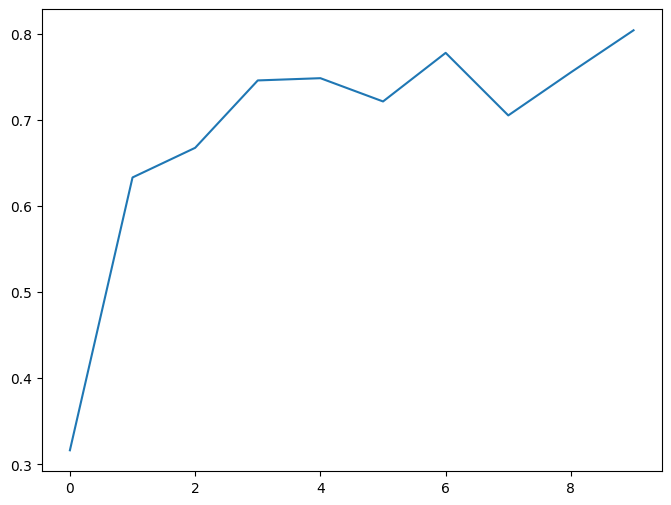

In [ ]:
# Plot validation accuracy (one chart)
plt.figure(figsize=(8,6))
for strat in strategies:
    h = histories[strat].history
    plt.plot(h['val_accuracy'], label=f"{strat} val_acc")
plt.title("Validation accuracy by pooling strategy")
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'avg'

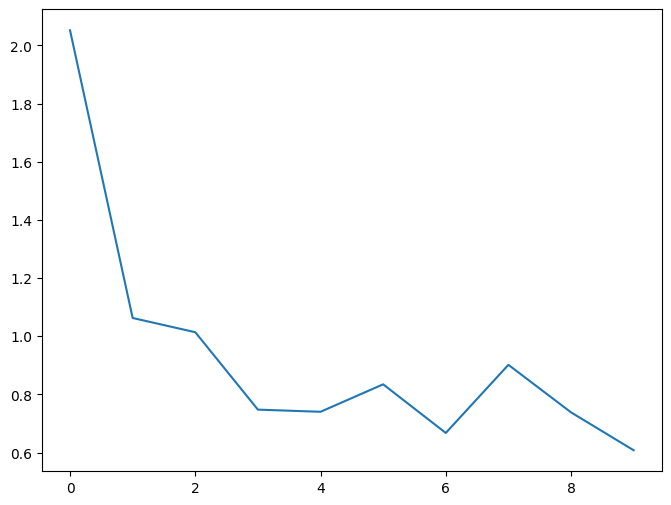

In [ ]:
# Plot validation loss (one chart)
plt.figure(figsize=(8,6))
for strat in strategies:
    h = histories[strat].history
    plt.plot(h['val_loss'], label=f"{strat} val_loss")
plt.title("Validation loss by pooling strategy")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Optionally: save DataFrame to CSV
df.to_csv("/content/pooling_models/pooling_comparison_results.csv", index=False)
print("Saved results CSV to /content/pooling_models/pooling_comparison_results.csv")

Saved results CSV to /content/pooling_models/pooling_comparison_results.csv
